In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import folium
from folium.plugins import HeatMap
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time
import pickle
from sklearn.neighbors import NearestNeighbors
import random

### **Step 10: Load Graph**

In [2]:
RoadNetwork = pd.read_csv('derived_data/downsampled_road_network.csv')
airports = pd.read_csv('derived_data/processed_airports.csv')

In [3]:
GRAPH_FILE = 'derived_data/road_airport_graph.pkl'

with open(GRAPH_FILE, 'rb') as f:
    G = pickle.load(f)
    print("Loaded saved graph from file.")

Loaded saved graph from file.


### **Step 11: Control Parameters**

In [4]:
time_steps = 200  # Simulation duration
R0 = 5  # Higher R0 for massive outbreak
INCUBATION_PERIOD = 5
INFECTION_PERIOD = 10

HANDWASH_EFFECT = 0.9   # Reduces beta by 10% (0.9 means 90% of the original rate)
MASK_EFFECT = 0.7       # Reduces beta by 30%
LOCKDOWN_EFFECT = 0.3   # Reduces beta by 70%
LOCKDOWN_DAY = 20       # Day when lockdown is imposed

beta, sigma, gamma = R0 / INFECTION_PERIOD, 1 / INCUBATION_PERIOD, 1 / INFECTION_PERIOD

### **Step 12: SEIR Initialization**

In [5]:
population = RoadNetwork['population_density'].values
num_nodes = len(G.nodes)

# Mobility Matrix
mobility_matrix = nx.to_numpy_array(G, weight='weight')

# Combine road and airport populations
airport_population = np.full(num_nodes - len(population), population.mean() * 0.1)  # Assign airports 10% mean pop
population = np.concatenate([population, airport_population])
population = np.maximum(population, 1e-3)  # Ensure no zero populations

# Initialize SEIR
S = population.copy()
E = np.zeros(num_nodes)
I = np.zeros(num_nodes)
R = np.zeros(num_nodes)

In [6]:
# Distribute initial infections to top 10 populated nodes
top_nodes = np.argsort(population)[-3:]
for node in top_nodes:
    I[node] = 100  # Higher initial infections
    S[node] -= 100

### **Step 13: SEIR Simulation**

100%|██████████| 200/200 [00:00<00:00, 345.43it/s]


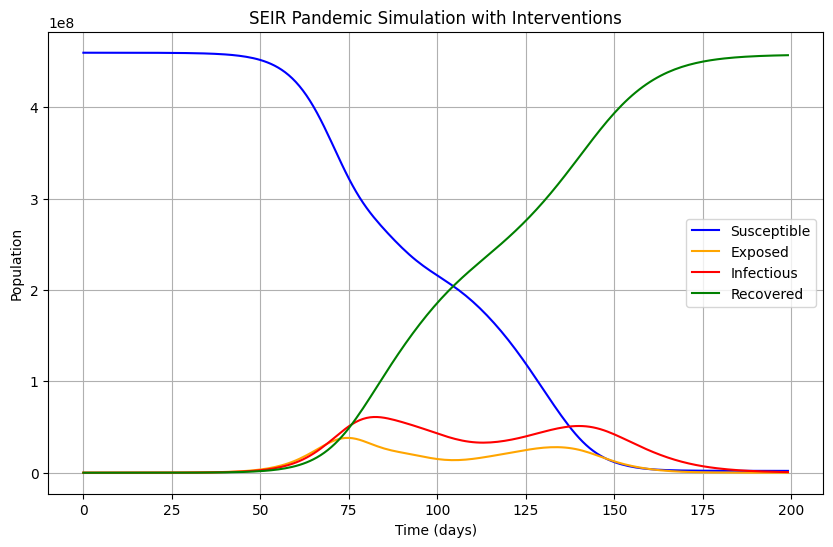

In [7]:
# Update beta dynamically during the simulation
results = {'S': [], 'E': [], 'I': [], 'R': []}
I_per_timestep = []

# Main SEIR Simulation with Interventions
for t in tqdm(range(time_steps)):
    # Apply damping factors
    current_beta = beta
    if t >= LOCKDOWN_DAY:
        current_beta *= LOCKDOWN_EFFECT  # Apply lockdown damping
    current_beta *= HANDWASH_EFFECT  # Always apply handwashing effect
    current_beta *= MASK_EFFECT      # Always apply mask usage effect

    # SEIR Model Equations with updated beta
    new_exposed = current_beta * S * (np.dot(mobility_matrix, I / population))
    new_exposed = np.minimum(new_exposed, S)  # Ensure we don't expose more than susceptible people

    new_infectious = sigma * E
    new_recovered = gamma * I

    S -= new_exposed
    E += new_exposed - new_infectious
    I += new_infectious - new_recovered
    R += new_recovered

    # Record results
    results['S'].append(S.sum())
    results['E'].append(E.sum())
    results['I'].append(I.sum())
    results['R'].append(R.sum())
    I_per_timestep.append(I.copy())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), results['S'], label="Susceptible", color='blue')
plt.plot(range(time_steps), results['E'], label="Exposed", color='orange')
plt.plot(range(time_steps), results['I'], label="Infectious", color='red')
plt.plot(range(time_steps), results['R'], label="Recovered", color='green')
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIR Pandemic Simulation with Interventions")
plt.legend()
plt.grid()
plt.show()


### **Step 14: Maps Generation**

In [8]:
# Ensure 'airports' has the correct column structure
airports_selected = airports[['lon', 'lat', 'population_density']]
airports_selected.columns = ['X', 'Y', 'population_density']  # Rename for consistency

# Concatenate with RoadNetwork
all_nodes = pd.concat([
    RoadNetwork[['X', 'Y', 'population_density']],
    airports_selected
], ignore_index=True)

# No need to reassign columns

all_nodes.reset_index(drop=True, inplace=True)

def update_map(I, t):
    map_center = [all_nodes['Y'].mean(), all_nodes['X'].mean()]
    disease_map = folium.Map(location=map_center, zoom_start=6)
    max_infections = max(I) if max(I) > 0 else 1
    normalized_infections = I / max_infections

    for i, node in all_nodes.iterrows():
        intensity = min(1, normalized_infections[i])
        folium.CircleMarker(
            location=(node['Y'], node['X']),
            radius=5 + 15 * intensity,
            color='red',
            fill=True,
            fill_opacity=0.6,
            popup=f"Day {t}: Infections {int(I[i])}",
        ).add_to(disease_map)

print("Generating interactive maps...")
for t, I in tqdm(enumerate(I_per_timestep)):
    update_map(I, t)

Generating interactive maps...


200it [00:49,  4.03it/s]


### **Step 15: Video Compilation**

Generating animated infection spread...


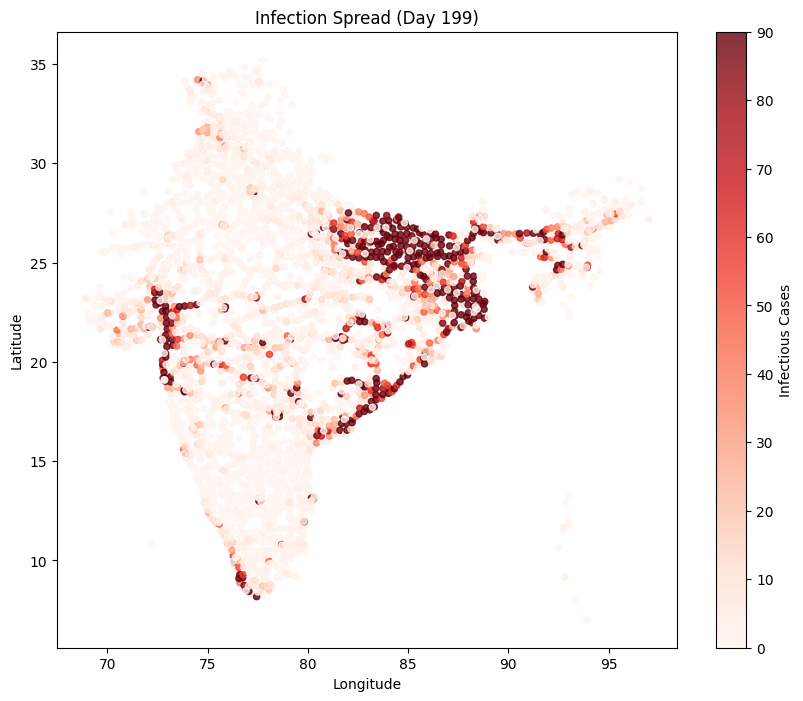

In [9]:
# %% Animated Infection Spread
def animate_infection_spread(I_per_timestep):
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(all_nodes['X'], all_nodes['Y'], c=I_per_timestep[0], cmap='Reds', s=20, alpha=0.8)
    ax.set_title("Infection Spread Over Time"), ax.set_xlabel("Longitude"), ax.set_ylabel("Latitude")
    colorbar = plt.colorbar(scatter, ax=ax)
    colorbar.set_label("Infectious Cases")

    def update(frame):
        scatter.set_array(I_per_timestep[frame])
        ax.set_title(f"Infection Spread (Day {frame})")
        return scatter,

    ani = FuncAnimation(fig, update, frames=len(I_per_timestep), blit=False)
    ani.save('infection_spread.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
    plt.show()

print("Generating animated infection spread...")
animate_infection_spread(I_per_timestep)